# Two-View Estimator

> Ayush Baid, Frank Dellaert

A notebook to investigate the TwoViewEstimator performance, using the Reichstag dataset.

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import gtsam
from gtsam import Pose3, PinholeCameraCal3Bundler

from gtsfm.loader.yfcc_imb_loader import YfccImbLoader
from gtsfm.frontend.detector_descriptor.sift import SIFTDetectorDescriptor
from gtsfm.frontend.matcher.twoway_matcher import TwoWayMatcher
from gtsfm.utils import viz
from gtsfm.frontend.verifier.ransac import Ransac
from gtsfm.two_view_estimator import TwoViewEstimator

In [2]:
cwd = Path.cwd()
folder_path = cwd = Path.cwd().parent / "tests"/ "data" / "imb_reichstag"

In [3]:
# Load Images
indices = [2, 5]
loader = YfccImbLoader(str(folder_path))
images = [loader.get_image(i) for i in indices]

In [4]:
# Detect features
detector_descriptor = SIFTDetectorDescriptor()
features = [detector_descriptor.detect_and_describe(image) for image in images]
for i,(f,d) in enumerate(features):
    print(f"image {i+1}: {d.shape[0]} features")

image 1: 4039 features
image 2: 4470 features


In [5]:
# Do matching
matcher = TwoWayMatcher(ratio_test_threshold=0.8)
keypoints_i1, descriptors_i1 = features[0]
keypoints_i2, descriptors_i2 = features[1]
image_shape_i1 = images[0].value_array.shape
image_shape_i2 = images[1].value_array.shape
match_indices = matcher.match(
    keypoints_i1, keypoints_i2, descriptors_i1, descriptors_i2, image_shape_i1, image_shape_i2
)
print(f"{match_indices.shape[0]} matched.")

177 matched.


In [6]:
# Get intrinsics
camera_intrinsics_i1, camera_intrinsics_i2 = [loader.get_camera_intrinsics_full_res(i) for i in indices]
print(camera_intrinsics_i1)

.K[1108.62659; 0; 0; 515; 342.5];



In [7]:
# Do verification
verifier = Ransac(use_intrinsics_in_verification=False,
                  estimation_threshold_px=2)
i2Ri1, i2Ui1, v_corr_idxs, inlier_ratio_est_model = verifier.verify(
    keypoints_i1, keypoints_i2, match_indices, camera_intrinsics_i1, camera_intrinsics_i2)
print(f"ypr={np.degrees(i2Ri1.xyz())}\nU={i2Ui1.point3().T}\nverified:{v_corr_idxs.shape}\n{inlier_ratio_est_model=}")

[2022-05-15 11:58:49,236 WARNING verification.py line 90 9369] Recovered R, t cannot create the input Essential Matrix
ypr=[  2.59618287 -20.14430129   0.48493447]
U=[0.56683547 0.10055135 0.81767168]
verified:(125, 2)
inlier_ratio_est_model=0.7062146892655368


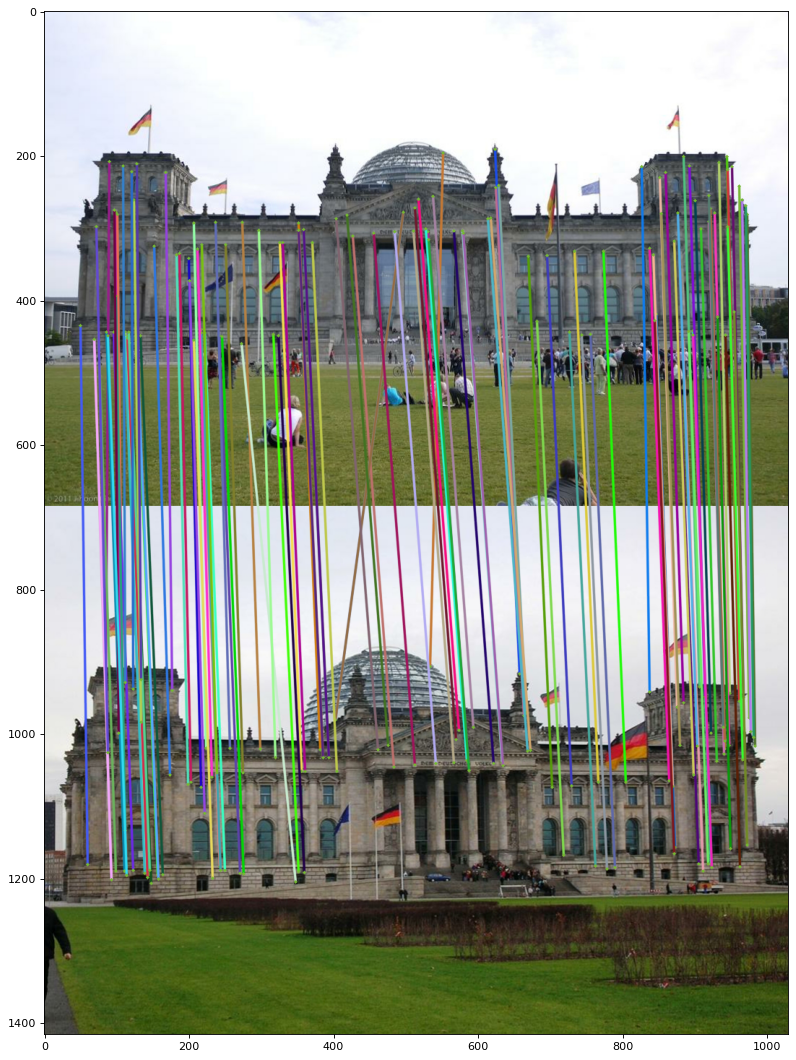

In [8]:
correspondence_image = viz.plot_twoview_correspondences(
    *images, keypoints_i1, keypoints_i2, v_corr_idxs, max_corrs=None)
fig = plt.figure(figsize=(12, 18), dpi=80)
fig.gca().imshow(correspondence_image.value_array)
plt.show()

In [9]:
# Create estimator
two_view_estimator = TwoViewEstimator(
    matcher=None, verifier=None, inlier_support_processor=None,
    bundle_adjust_2view=True, eval_threshold_px=4
)

In [10]:
# Sanity-check triangulation
i2Ti1_initial = Pose3(i2Ri1, i2Ui1.point3())
camera_i1 = PinholeCameraCal3Bundler(Pose3(), camera_intrinsics_i1)
camera_i2 = PinholeCameraCal3Bundler(
    i2Ti1_initial.inverse(), camera_intrinsics_i2)
tracks_3d, _ = two_view_estimator.triangulate_two_view_correspondences(
    camera_i1, camera_i2, keypoints_i1, keypoints_i2, v_corr_idxs)
points = np.array([t.point3() for t in tracks_3d]).T
print(points.shape)
fig = px.scatter_3d(x=points[0], y=points[2], z=-points[1])
fig.update_layout(scene=dict(aspectmode='data'))
fig.update_traces(marker_size=3)


(3, 125)


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'x=%{x}<br>y=%{y}<br>z=%{z}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'size': 3, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'scene': 'scene',
              'showlegend': False,
              'type': 'scatter3d',
              'x': array([ 0.66561509,  0.6324529 ,  0.64489546,  0.30161151,  0.53766007,
                          -0.03397096,  0.05336426, -0.25043127,  0.14854965, -0.3829268 ,
                          -0.38158806,  0.62171363,  0.54527439, -0.11394865,  0.55599065,
                          -0.37532096, -0.24461271, -0.49812368, -0.35113551, -0.52929847,
                          -0.49363343, -0.49534752, -0.03397096, -0.47371995, -0.1252996 ,
                           0.32624872, -0.49534752,  0.15050437, -0.34578863,  0.15614092,
                           0.57583406,  0.68977463,  0.37342686, -0.49023552, -0.34522632,
                           0.52186167, -0.48045424,  0.48342493, -0.54844567,  0.60873478,
                           0.02135177,  0.63657158, -0.47926961,  0.67737054, -0.24812319,
                          -0.54634534,  0.34380903,  0.62939561, -0.31698209, -0.07763557,
                          -0.54634534,  0.47049184,  0.06858117, -0.52666884,  0.48342493,
                          -0.5158174 ,  0.08481824, -0.39296284, -0.49190525,  0.48797524,
                           0.68406182, -0.29167645, -0.5280209 , -0.21835034, -0.19214662,
                          -0.38611421, -0.57701294, -0.54064503,  0.55035244,  0.01712139,
                           0.59724129, -0.03913441,  0.47866376, -0.42876594, -0.21666468,
                           0.55361964,  0.6272657 ,  0.47091544, -0.4247596 ,  0.13637218,
                           0.31335383, -0.52363846,  0.59378382, -0.49912752, -0.20738857,
                          -0.52240359,  0.64990696, -0.20738857,  0.47941741,  0.56394034,
                           0.13182557,  0.2192748 , -0.50049731,  0.02177974, -0.1430744 ,
                          -0.21666468,  0.5004539 , -0.40148097,  0.02858102,  0.53196448,
                          -0.55098759, -0.53219253, -0.36447223, -0.25783988,  0.08679387,
                           0.25781719,  0.59772651, -0.40893383,  0.49219286, -0.40448068,
                           0.59294658,  0.51504863, -0.00421472, -0.46045646, -0.00551395,
                           0.61792218,  0.23494277, -0.29005046, -0.49976053, -0.3939557 ,
                          -0.50971894,  0.0021679 , -0.52557578,  0.52042181, -0.45239164]),
              'y': array([1.66317503, 1.65014562, 1.65198777, 1.56786647, 1.63051878, 2.0128126 ,
                          1.73224081, 1.47040339, 1.56014864, 1.4233893 , 1.42414755, 1.66242766,
                          1.59857781, 1.43808553, 1.60595351, 1.42493721, 1.47019137, 1.37333458,
                          1.43001355, 1.40936189, 1.37381902, 1.37606631, 2.0128126 , 1.37850095,
                          1.43209285, 1.57217778, 1.37606631, 1.54335942, 1.43172776, 1.54876063,
                          1.62844602, 1.67690586, 1.5997365 , 1.37427595, 1.44955113, 1.59373526,
                          1.3774176 , 1.61281071, 1.42818082, 1.64129267, 1.46797785, 1.65272079,
                          1.37765325, 1.67447079, 1.45107064, 1.36248368, 1.5757253 , 1.62476468,
                          1.46026161, 1.44517547, 1.36248368, 1.69258618, 1.47737745, 1.41100373,
                          1.61281071, 1.37002919, 1.47988729, 1.4412157 , 1.37532593, 1.62275666,
                          1.67469111, 1.34010158, 1.36791525, 1.48036225, 1.48009728, 1.44219745,
                          1.37951862, 1.3652596 , 1.63212419, 1.46623604, 1.63626269, 1.45395531,
                          1.61845069, 1.43529431, 1.47222047, 1.60079133, 1.62371059, 1.61830156,
                          1.43725481, 1.48626937, 1.58680372, 1.40004794, 1.63314519, 1.37299

In [ ]:
i2Ri1_optimized, i2Ui1_optimized, corr_idxs = two_view_estimator.bundle_adjust(
    keypoints_i1, keypoints_i2, v_corr_idxs, camera_intrinsics_i1, camera_intrinsics_i2, i2Ri1, i2Ui1)
print(f"ypr={np.degrees(i2Ri1_optimized.xyz())}\nU={i2Ui1_optimized.point3().T}\nverified:{corr_idxs.shape}")

[2022-05-07 14:04:10,143 DEBUG two_view_estimator.py line 174 95629] Performed DA in 0.003258 seconds.
[2022-05-07 14:04:10,144 DEBUG two_view_estimator.py line 175 95629] Triangulation succeeded on 125 correspondences.
[2022-05-07 14:04:10,145 INFO bundle_adjustment.py line 193 95629] Input: 125 tracks on 2 cameras

[2022-05-07 14:04:11,104 INFO bundle_adjustment.py line 211 95629] initial error: 570.81
[2022-05-07 14:04:11,104 INFO bundle_adjustment.py line 212 95629] final error: 7.64
[2022-05-07 14:04:11,127 INFO bundle_adjustment.py line 218 95629] [Result] Number of tracks before filtering: 125
[2022-05-07 14:04:11,132 INFO bundle_adjustment.py line 227 95629] [Result] Number of tracks after filtering: 118
[2022-05-07 14:04:11,133 DEBUG two_view_estimator.py line 191 95629] Performed 2-view BA in 0.988571 seconds.
ypr=[  1.27586227 -16.00271097   0.54841626]
U=[0.41065338 0.06390306 0.90954945]
verified:(118, 2)


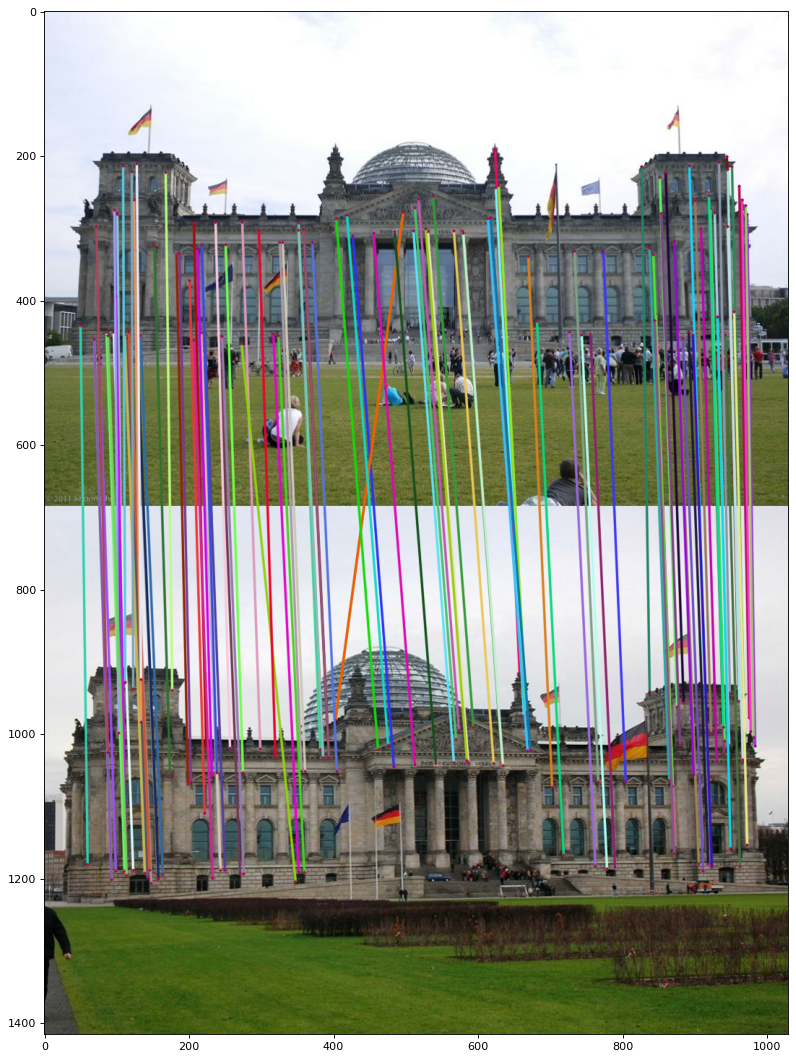

In [ ]:
correspondence_image = viz.plot_twoview_correspondences(*images, keypoints_i1, keypoints_i2, corr_idxs, max_corrs=None)
fig = plt.figure(figsize=(12, 18), dpi=80)
fig.gca().imshow(correspondence_image.value_array)
plt.show()

In [ ]:
# Sanity-check triangulation after BA
i2Ti1_optimized = Pose3(i2Ri1_optimized, i2Ui1_optimized.point3())
camera_i1 = PinholeCameraCal3Bundler(Pose3(), camera_intrinsics_i1)
camera_i2 = PinholeCameraCal3Bundler(
    i2Ti1_optimized.inverse(), camera_intrinsics_i2)
ba_tracks_3d, _= two_view_estimator.triangulate_two_view_correspondences(
    camera_i1, camera_i2, keypoints_i1, keypoints_i2, corr_idxs)
ba_points = np.array([t.point3() for t in ba_tracks_3d]).T
print(ba_points.shape)
fig = px.scatter_3d(x=ba_points[0], y=ba_points[2], z=-ba_points[1])
fig.update_layout(scene=dict(aspectmode='data'))
fig.update_traces(marker_size = 3)

(3, 118)
